In [1]:
from pathlib import Path

base_dir = Path(r"D:/Data/raw")
pattern = "*.nidq.meta"

folders = sorted({p.parent for p in base_dir.rglob(pattern)})
# Explanation: 
#   p.parent      -> folder containing the .meta file
#   p.parent.parent -> one level up (e.g. D:\Data\7633_naive)

for f in folders:
    print(f)


D:\Data\raw\3198-51\51_naive
D:\Data\raw\3198-51\51_recall
D:\Data\raw\3198-52\52_naive
D:\Data\raw\3198-52\52_recall
D:\Data\raw\3556-17\17_naive
D:\Data\raw\3556-17\17_recall
D:\Data\raw\7633_naive
D:\Data\raw\7633_recall
D:\Data\raw\7644_naive
D:\Data\raw\7644_recall


In [5]:



def extract_ttl_edges_auto(signal, fs, hysteresis=0.1):
    """Detect TTL edges robustly from analog signal using percentile-based thresholds."""
    signal_f = medfilt(signal, kernel_size=5)
    
    v_low = np.percentile(signal_f, 5)   # bottom 5% of values
    v_high = np.percentile(signal_f, 95) # top 5% of values
    
    v_mid_low = v_low + hysteresis * (v_high - v_low)
    v_mid_high = v_high - hysteresis * (v_high - v_low)

    digital = np.zeros_like(signal_f, dtype=int)
    state = 0
    for i, v in enumerate(signal_f):
        if state == 0 and v > v_mid_high:
            state = 1
        elif state == 1 and v < v_mid_low:
            state = 0
        digital[i] = state

    return digital

def quadrature_speed_direction(sigA, sigB, fs, pulses_per_rev=360, hysteresis=0.1):
    """Compute speed (deg/s) and direction (1=CW, -1=CCW, 0=no movement)."""
    sig_len = len(sigA)
    time_full = np.arange(sig_len) / fs  # seconds

    # convert to digital
    digA = extract_ttl_edges_auto(sigA, fs, hysteresis)
    digB = extract_ttl_edges_auto(sigB, fs, hysteresis)

    # detect rising edges on channel A
    rising_A = np.where((digA[1:] > digA[:-1]) & (digA[:-1] == 0))[0] + 1
    t_edges = rising_A / fs

    # compute incremental rotation
    direction_edges = np.where(digB[rising_A] == 0, 1, -1)
    deg_per_edge = 360.0 / pulses_per_rev
    dtheta = direction_edges * deg_per_edge

    # instantaneous speed between pulses
    dt = np.diff(t_edges)
    speed_edges = np.diff(np.cumsum(dtheta)) / dt
    dir_edges = direction_edges[1:]

    # interpolate speed and direction to full sample times
    if len(t_edges) > 1:
        f_speed = interp1d((t_edges[1:] + t_edges[:-1])/2, speed_edges,
                           kind='previous', bounds_error=False, fill_value=0)
        f_dir = interp1d((t_edges[1:] + t_edges[:-1])/2, dir_edges,
                         kind='previous', bounds_error=False, fill_value=0)
        speed_full = f_speed(time_full)
        dir_full = f_dir(time_full)
    else:
        speed_full = np.zeros(sig_len)
        dir_full = np.zeros(sig_len)

    return time_full*1000, speed_full, dir_full  # time in ms


    





SpikeGLXRecordingExtractor: 9 channels - 11573.700000 Hz - 1 segments - 52,998,637 samples 
                            4,579.23s (1.27 hours) - int16 dtype - 909.78 MiB


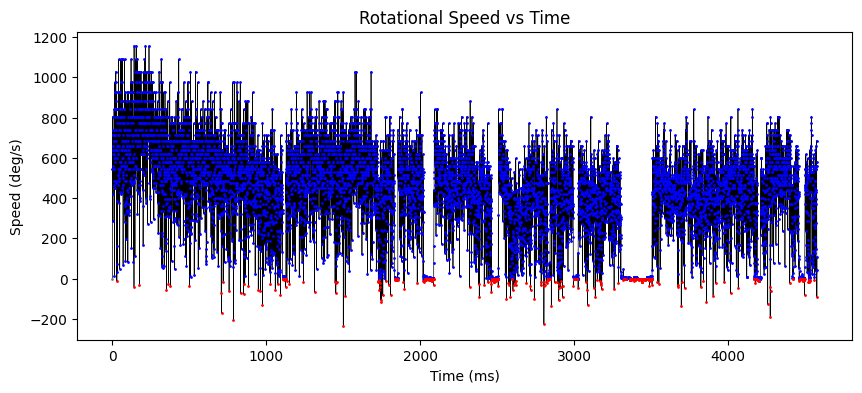

SpikeGLXRecordingExtractor: 9 channels - 11573.700000 Hz - 1 segments - 53,366,894 samples 
                            4,611.05s (1.28 hours) - int16 dtype - 916.10 MiB


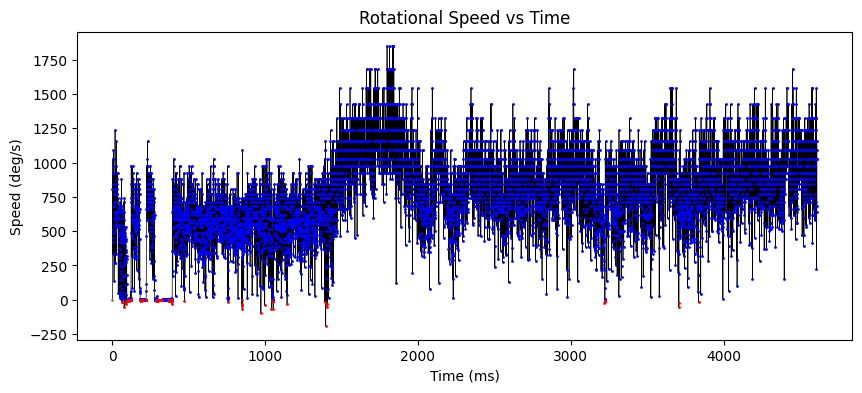

Skipping 52_naive, file already exists.
Skipping 52_recall, file already exists.
SpikeGLXRecordingExtractor: 9 channels - 11573.700000 Hz - 1 segments - 54,011,012 samples 
                            4,666.70s (1.30 hours) - int16 dtype - 927.16 MiB


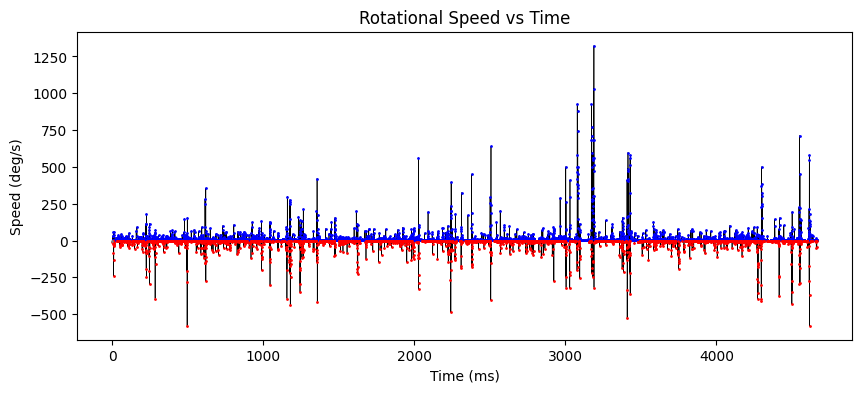

SpikeGLXRecordingExtractor: 9 channels - 11573.700000 Hz - 1 segments - 28,373,992 samples 
                            2,451.59s (40.86 minutes) - int16 dtype - 487.07 MiB


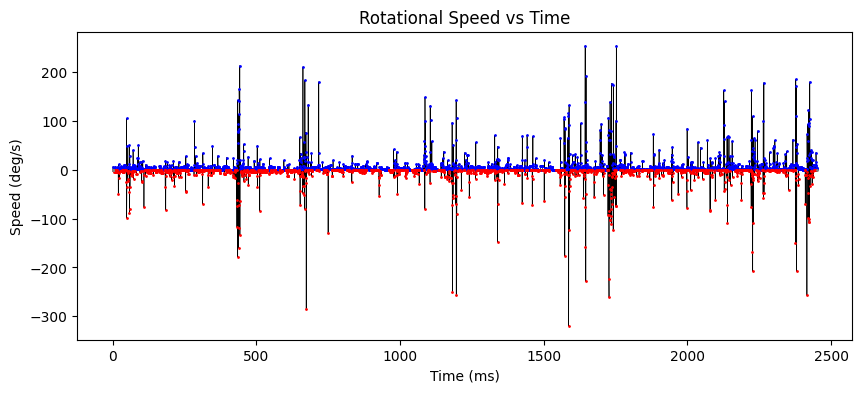

Skipping 7633_naive, file already exists.
Skipping 7633_recall, file already exists.
Skipping 7644_naive, file already exists.
Skipping 7644_recall, file already exists.
done


In [6]:
import spikeinterface.full as si
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd 
import os, sys
import shutil
from pprint import pprint 
import time as time

from scipy.signal import medfilt
from scipy.interpolate import interp1d

#base_dir = Path(r"D:/Data/raw")
#pattern = "*_t0.nidq.meta"
#folders = sorted({p.parent for p in base_dir.rglob(pattern)})

output_dir = Path(r"D:\Data\speeds")
output_dir.mkdir(exist_ok=True)

for f in folders:
    basefolder = f
    folder_name = Path(basefolder).name
    out_path = output_dir / f"{folder_name}.csv"

    # --- SKIP IF FILE ALREADY EXISTS ---
    if out_path.exists():
        print(f"Skipping {folder_name}, file already exists.")
        continue

    event = si.read_spikeglx(basefolder, stream_id='nidq', load_sync_channel=False)
    print(event)

    fs = event.get_sampling_frequency()
    sigA = event.get_traces(channel_ids=[event.get_channel_ids()[6]]).squeeze()
    sigB = event.get_traces(channel_ids=[event.get_channel_ids()[5]]).squeeze()
    ts_ms, speed, direction = quadrature_speed_direction(sigA, sigB, fs, pulses_per_rev=225)

    df = pd.DataFrame({
        'sample': ts_ms,
        'speed': speed,
        'direction': direction
    })
    df.to_csv(out_path, index=False)

    downsample_factor = 6000
    ts_plot = ts_ms[::downsample_factor] / 1000
    speed_plot = speed[::downsample_factor]
    dir_plot = direction[::downsample_factor]

    plt.figure(figsize=(10, 4))
    colors = np.where(dir_plot == 1, 'blue',
                      np.where(dir_plot == -1, 'red', 'gray'))
    plt.plot(ts_plot, speed_plot, color='black', linewidth=0.5)
    for d_color in [1, -1, 0]:
        mask = dir_plot == d_color
        plt.plot(
            ts_plot[mask],
            speed_plot[mask],
            '.',
            color={1: 'blue', -1: 'red', 0: 'gray'}[d_color],
            markersize=2
        )

    plt.xlabel("Time (ms)")
    plt.ylabel("Speed (deg/s)")
    plt.title("Rotational Speed vs Time")
    plt.show()

print('done')
